# 导库、加载深度学习框架、加载图像处理库

In [1]:
# 基本库
import pandas as pd
import numpy as np

# 绘图库
from matplotlib import pyplot as plt
import seaborn as sns
from pyecharts.charts import Bar
from pyecharts import options as opts
from pyecharts.globals import ThemeType

# 搭建分类模型所需要的库
from keras.models import Sequential    # 序贯模型
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout    # 各种层
from keras.optimizers import SGD, Adam    # 优化器
from keras.callbacks import ReduceLROnPlateau    # 回调函数
from keras.utils import np_utils    # utils工具
from keras.utils.vis_utils import plot_model    # 绘制模型的结构图
from keras.utils import to_categorical
from keras import backend as K    # keras后端
K.set_image_data_format('channels_first')    # 设置图像的维度顺序（‘tf’或‘th’）
from keras.models import load_model    # 模型加载
from keras.utils.generic_utils import get_custom_objects    # 检索全局定制类
from sklearn.metrics import confusion_matrix    # 混淆矩阵

# 图像处理库
import cv2
from keras.preprocessing import image    # 图像处理
from keras.preprocessing.image import ImageDataGenerator    # 图像生成器

Using TensorFlow backend.


# 数据预处理

## 查看数据集

In [2]:
Dataset = pd.read_csv('../Dataset/fer2013.csv')

In [3]:
Emotion = ["Angry","Disgust","Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [4]:
print("数据集形状：",Dataset.values.shape)
Dataset.head()

数据集形状： (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
print("数据集使用类别：\n",Dataset.Usage.value_counts())

数据集使用类别：
 Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


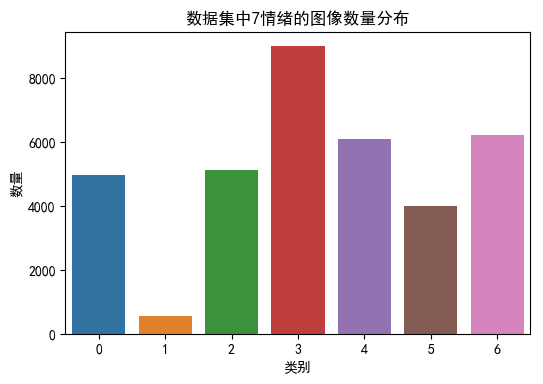

In [6]:
plt.figure(figsize=(6,4), dpi=100)
sns.barplot(Dataset['emotion'].value_counts().index,Dataset['emotion'].value_counts().values)
# 设置标签
plt.xlabel('类别')
plt.ylabel('数量')
# 设置中文
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
# 设置标题
plt.title("数据集中7情绪的图像数量分布")

plt.show()

In [7]:
xaxis = Emotion
yaxis = Dataset['emotion'].value_counts(sort=False).values.tolist()
bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .add_xaxis(xaxis)
    .add_yaxis("", yaxis)
    .set_global_opts(title_opts={"text": "数据集中7情绪的图像数量分布", "subtext": "pyecharts"})
)
bar.render_notebook()

## 数据预处理

In [9]:
# 划分训练数据集和测试数据集
train = Dataset[Dataset["Usage"] == "Training"]
test = Dataset[Dataset["Usage"] == "PublicTest"]
# test1 = Dataset[Dataset["Usage"] == "PublicTest"]
# test2 = Dataset[Dataset["Usage"] == "PrivateTest"]
# test = test1.append(test2)

# 将""分隔的像素值转换为列表
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

print('训练集的形状',train.shape)
print('测试集的形状',test.shape)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


训练集的形状 (28709, 3)
测试集的形状 (3589, 3)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
train.pixels[0]

array([ 70.,  80.,  82., ..., 106., 109.,  82.])

In [25]:
train.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [38]:
train.iloc[:2,:3].values

array([[0, array([ 70.,  80.,  82., ..., 106., 109.,  82.]), 'Training'],
       [0, array([151., 150., 147., ..., 193., 183., 184.]), 'Training']],
      dtype=object)

In [9]:
#划分训练数据集和测试数据集
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

# np.vstack 垂直顺序堆叠数组（按行选择元素）
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

# 以所需格式重塑 X_train、y_train、X_test、y_test
X_train = np.reshape(X_train, (X_train.shape[0],1,48,48))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],1,48,48))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("X_train和y_train的形状分别是：" + str(X_train.shape) +" 和 " + str(y_train.shape))
print("X_test和y_test的形状分别是：" + str(X_test.shape) +" 和 " + str(y_test.shape))

X_train和y_train的形状分别是：(28709, 1, 48, 48) 和 (28709, 1)
X_test和y_test的形状分别是：(3589, 1, 48, 48) 和 (3589, 1)


In [10]:
X_train[0]

array([[[ 70.,  80.,  82., ...,  52.,  43.,  41.],
        [ 65.,  61.,  58., ...,  56.,  52.,  44.],
        [ 50.,  43.,  54., ...,  49.,  56.,  47.],
        ...,
        [ 91.,  65.,  42., ...,  72.,  56.,  43.],
        [ 77.,  82.,  79., ..., 105.,  70.,  46.],
        [ 77.,  72.,  84., ..., 106., 109.,  82.]]])

In [11]:
y_train[0]

array([0], dtype=int64)

In [12]:
# 将数据更改为浮点数据类型
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# 将数据缩放到 0 到 1 之间
train_data /= 255
test_data /= 255

# 将类别向量映射为二值类别矩阵
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [13]:
train_data[0]

array([[[0.27450982, 0.3137255 , 0.32156864, ..., 0.20392157,
         0.16862746, 0.16078432],
        [0.25490198, 0.23921569, 0.22745098, ..., 0.21960784,
         0.20392157, 0.17254902],
        [0.19607843, 0.16862746, 0.21176471, ..., 0.19215687,
         0.21960784, 0.18431373],
        ...,
        [0.35686275, 0.25490198, 0.16470589, ..., 0.28235295,
         0.21960784, 0.16862746],
        [0.3019608 , 0.32156864, 0.30980393, ..., 0.4117647 ,
         0.27450982, 0.18039216],
        [0.3019608 , 0.28235295, 0.32941177, ..., 0.41568628,
         0.42745098, 0.32156864]]], dtype=float32)

In [14]:
train_labels_one_hot[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
print ("train_data 和 train_labels_one_hot 的形状分别是：" + str(train_data.shape) +" 和 " + str(train_labels_one_hot.shape))
print ("test_data 和 test_labels_one_hot 的形状分别是：" + str(test_data.shape) +" 和 " + str(test_labels_one_hot.shape))

train_data 和 train_labels_one_hot 的形状分别是：(28709, 1, 48, 48) 和 (28709, 7)
test_data 和 test_labels_one_hot 的形状分别是：(3589, 1, 48, 48) 和 (3589, 7)


## 数据可视化

In [16]:
# 定义标签
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5,1,'测试数据集中的第二张图像的情绪 : Disgust')

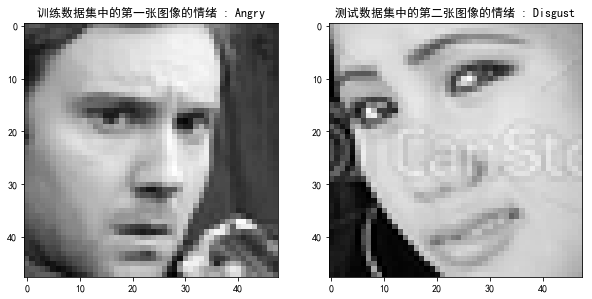

In [17]:
plt.figure(figsize=[10,5])

# 显示训练数据集中的第一张图像
plt.subplot(121)
plt.imshow(X_train[0].reshape((48, 48)), interpolation='none', cmap='gray')
plt.title("训练数据集中的第一张图像的情绪 : {}".format(get_label(int(y_train[0]))))

# 显示测试数据集中的第二张图像
plt.subplot(122)
plt.imshow(X_test[1].reshape((48, 48)), interpolation='none', cmap='gray')
plt.title("测试数据集中的第二张图像的情绪 : {}".format(get_label(int(y_test[1]))))

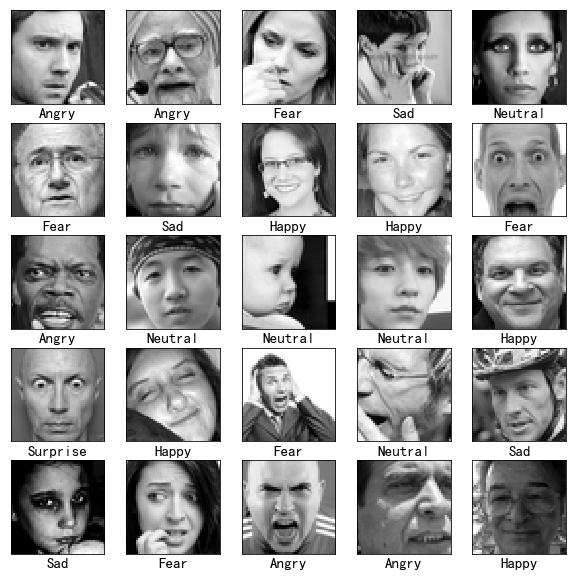

In [19]:
# 显示训练数据集中的前25张图像
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((48, 48)), interpolation='none', cmap='gray')
    plt.xlabel(get_label(int(y_train[i])), fontsize=15)
plt.show()

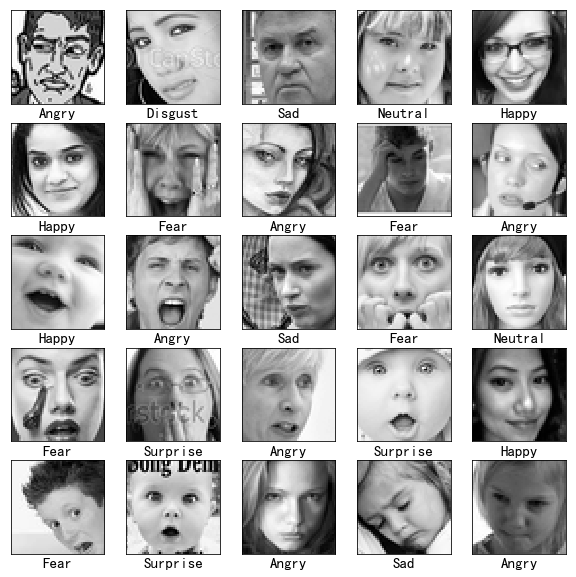

In [20]:
# 显示测试数据集中的前25张图像
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape((48, 48)), interpolation='none', cmap='gray')
    plt.xlabel(get_label(int(y_test[i])), fontsize=15)
plt.show()

# 搭建和训练深度学习模型

In [20]:
#数据增强
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  #2,4
        zoom_range = 0.0,  #0.2
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, #True
        vertical_flip=False)  

datagen.fit(train_data)

D:\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  ' channels).')


In [21]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

D:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [22]:
# 从训练标签中找到唯一的数字
classes = np.unique(y_train)
nClasses = len(classes)
print('标签总数 : ', nClasses)
print('输出的标签类别 : ', classes)

# 查找输入图像的形状并创建变量 input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
print("输入图像的形状",input_shape)

标签总数 :  7
输出的标签类别 :  [0 1 2 3 4 5 6]
输入图像的形状 (1, 48, 48)


In [23]:
# def swish_activation(x):
#     return (K.sigmoid(x) * x)

## 搭建CNN网络

In [24]:
#构建序贯模型
model = Sequential()

#输入层
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=input_shape))

#其他层
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), padding="same", activation='relu'))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Flatten层
model.add(Flatten())

#全连接层
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

#输出层
model.add(Dense(7 , activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 48, 48)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 24, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 24, 24)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 12, 12)       

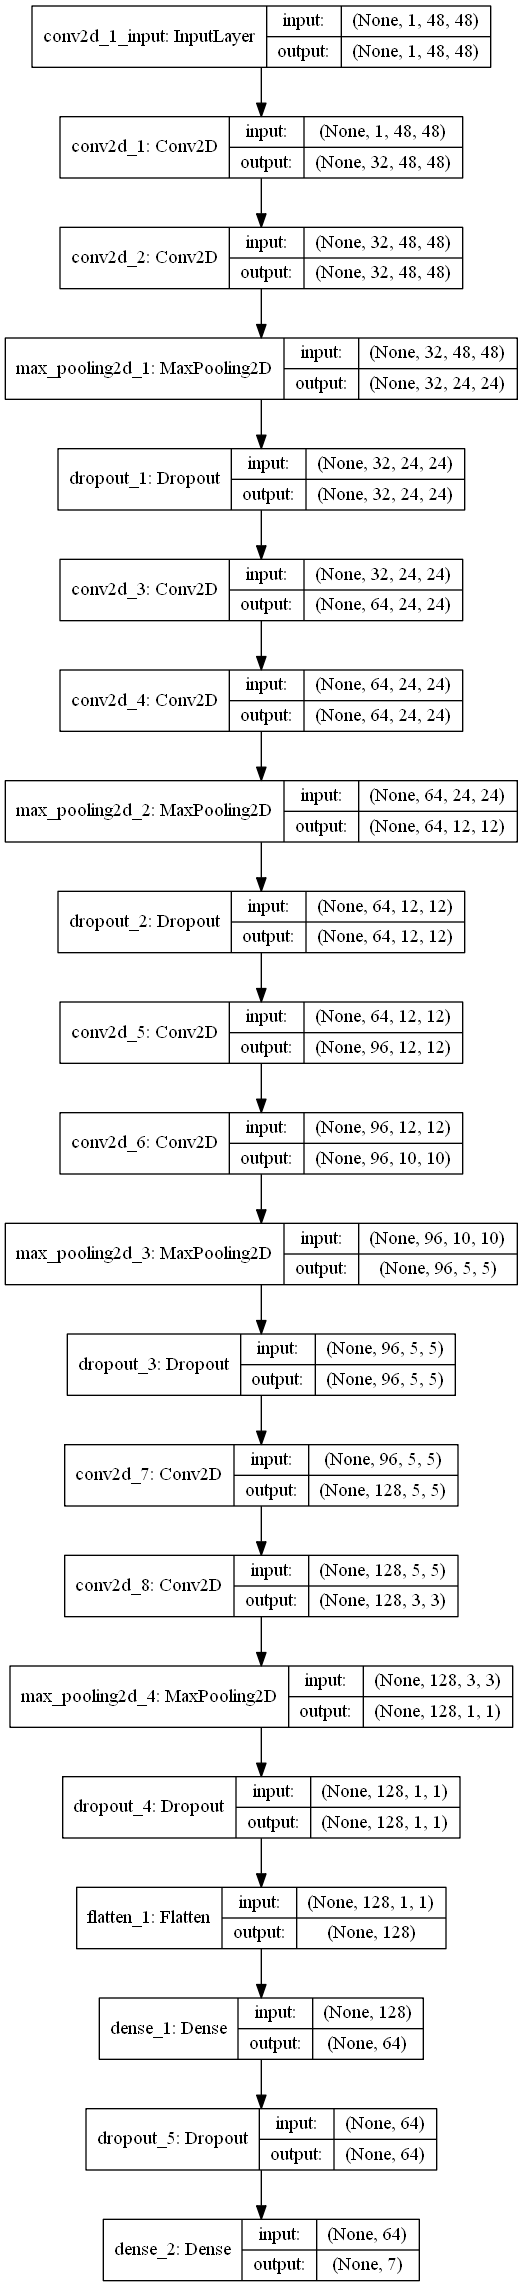

In [25]:
plot_model(model, to_file='../Model_Accuracy/改进模型2/改进模型2.png', show_shapes=True, show_layer_names=True)

## 训练模型

In [26]:
batch_size = 128
epochs = 46 #46

# model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy']) #categorical_crossentropy、binary_crossentropy

In [27]:
history = model.fit_generator(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
                    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                    callbacks=[lr_reduce],
                    validation_data=(test_data, test_labels_one_hot),
                    epochs = epochs, verbose = 2)

D:\Anaconda3\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/46
 - 41s - loss: 1.8324 - accuracy: 0.2441 - val_loss: 1.8105 - val_accuracy: 0.2494
Epoch 2/46


D:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 33s - loss: 1.8136 - accuracy: 0.2489 - val_loss: 1.7733 - val_accuracy: 0.2494
Epoch 3/46
 - 34s - loss: 1.7414 - accuracy: 0.2825 - val_loss: 1.6310 - val_accuracy: 0.3341
Epoch 4/46
 - 33s - loss: 1.6117 - accuracy: 0.3529 - val_loss: 1.4664 - val_accuracy: 0.4288
Epoch 5/46
 - 34s - loss: 1.5004 - accuracy: 0.4107 - val_loss: 1.4022 - val_accuracy: 0.4503
Epoch 6/46
 - 33s - loss: 1.4164 - accuracy: 0.4496 - val_loss: 1.3082 - val_accuracy: 0.4870
Epoch 7/46
 - 34s - loss: 1.3562 - accuracy: 0.4749 - val_loss: 1.2531 - val_accuracy: 0.5124
Epoch 8/46
 - 33s - loss: 1.3121 - accuracy: 0.4985 - val_loss: 1.2304 - val_accuracy: 0.5208
Epoch 9/46
 - 34s - loss: 1.2647 - accuracy: 0.5188 - val_loss: 1.2029 - val_accuracy: 0.5358
Epoch 10/46
 - 34s - loss: 1.2410 - accuracy: 0.5280 - val_loss: 1.1837 - val_accuracy: 0.5433
Epoch 11/46
 - 34s - loss: 1.2108 - accuracy: 0.5409 - val_loss: 1.1487 - val_accuracy: 0.5567
Epoch 12/46
 - 34s - loss: 1.1941 - accuracy: 0.5501 - val_loss: 1.15

## 评估模型

In [28]:
#总体评估
score = model.evaluate(test_data, test_labels_one_hot)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3589/3589 [==============================] - 1s 270us/step
Test loss: 1.0328703009009395
Test accuracy: 0.6271942257881165


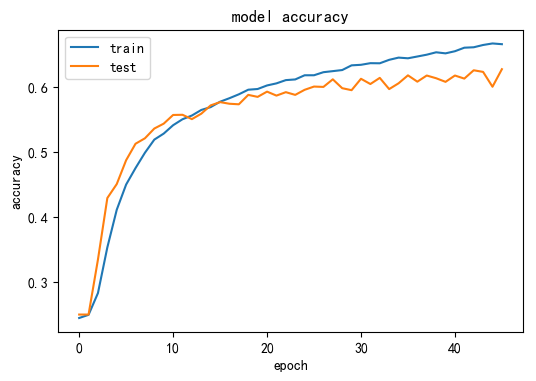

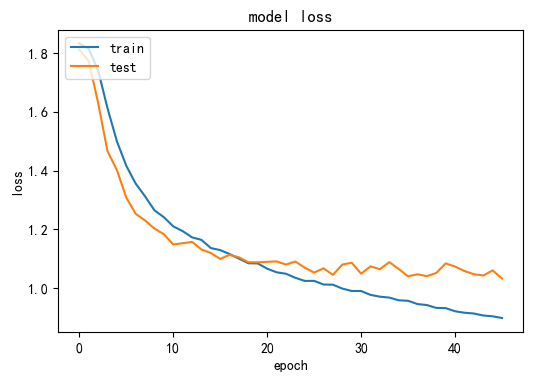

In [29]:
#训练历史可视化
plt.figure(figsize=(6,4), dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('../Model_Accuracy/改进模型2/epochs46_accuracy.png')
plt.show()

plt.figure(figsize=(6,4), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('../Model_Accuracy/改进模型2/epochs46_loss.png')
plt.show()

In [30]:
# 保存模型
print("Saving model to disk")
mp = "../Models/改进模型2_epochs46.h5"
model.save(mp)

Saving model to disk


# 加载训练模型进行图像的情绪预测

In [31]:
# 模型加载
# def swish_activation(x):
#         return (K.sigmoid(x) * x)
# get_custom_objects().update({'swish_activation': Activation(swish_activation)})

model = load_model("../Models/改进模型2_epochs46.h5")

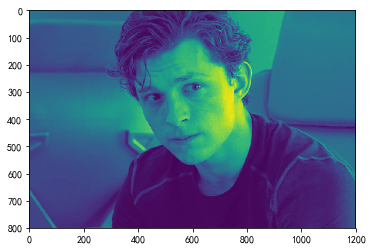

In [32]:
picture = cv2.imread('../Images/sad.jpg', 0)    # 1、0、-1cv2.IMREAD_GRAYSCALE
plt.imshow(picture)

In [33]:
img = image.load_img("../Images/sad.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255
x = x.reshape([x.shape[0], 1, 48, 48])

custom = model.predict(x)
#绘制预测结果
xaxis = Emotion
yaxis = [round(i,4) for i in custom[0].tolist()]
bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.ESSOS))
    .add_xaxis(xaxis)
    .add_yaxis("", yaxis)
    .set_global_opts(title_opts={"text": "情绪分析", "subtext": "pyecharts"})
)
bar.render_notebook()

D:\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# 三种模型的分析

In [12]:
def plot_confuse(path, test_data, test_labels_one_hot):
    model = load_model(path)
    
    test_pred = model.predict_classes(test_data)
    test_labels_one_hot = test_labels_one_hot.argmax(axis=-1)
    
    con_mat = confusion_matrix(test_labels_one_hot, test_pred)
    con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # 归一化
    con_mat_norm = np.around(con_mat_norm, decimals=2)

    # === plot ===
    plt.figure(figsize=(5, 5))
    sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
    
    title = path.split('/')[2].split('.')[0]
    plt.ylim(0, 7)
    # 设置中文
    plt.rcParams['font.sans-serif'] = ['simhei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置标题
    plt.title(title+'的混淆矩阵')
    # 设置标签
    plt.xlabel('预测类别')
    plt.ylabel('真实类别')
    plt.show()

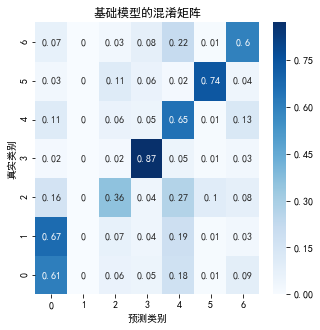

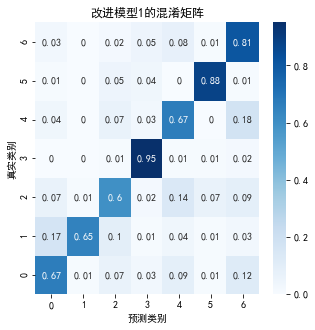

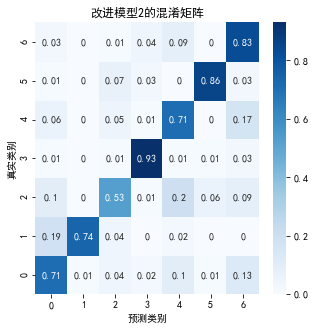

In [13]:
First = "../Models/基础模型.h5"
Second = "../Models/改进模型1.h5"
Third = "../Models/改进模型2.h5"
plot_confuse(First, train_data, train_labels_one_hot)
plot_confuse(Second, train_data, train_labels_one_hot)
plot_confuse(Third, train_data, train_labels_one_hot)